In [1]:
import pandas as pd
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='paper')
import numpy as np
from util import color_list,markertype_list
from collections import defaultdict

In [2]:
def pn_distance(a, b, p):
    x = a.quantile(p)
    y = b.quantile(p)
    return (y - x) / x
    
def p99_distance(a, b):
    return pn_distance(a, b, 0.99)

P99_PERCENTILE_LIST = np.arange(1, 101, 1)

MTU=1000
BDP = 10 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]
labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=5BDP', 3:'5BDP<size'}

n_size_bucket_list_output=len(bin_size_list)+1
n_percentiles=len(P99_PERCENTILE_LIST)

file2matrix = {
    '../../workload/spatials/cluster_a_2_16.json': 'Matrix A',
    '../../workload/spatials/cluster_b_2_16.json': 'Matrix B',
    '../../workload/spatials/cluster_c_2_16.json': 'Matrix C',
}
file2dist = {
    '../../workload/distributions/facebook/webserver-all.txt': 'WebServer',
    '../../workload/distributions/facebook/hadoop-all.txt': 'Hadoop',
    '../../workload/distributions/facebook/cachefollower-all.txt': 'CacheFollower',
}
file2oversub = {
    'spec/cluster_1_to_1.json': '1-to-1',
    'spec/cluster_2_to_1.json': '2-to-1',
    'spec/cluster_4_to_1.json': '4-to-1',
}
root_dir_baseline="../data"

In [3]:
shard_seed=2
mlsys_dir=f'mlsys_s{shard_seed}'
N_FLOW_THRESHOLD=1
NR_PATHS_SAMPLED=500
NR_INTEPOLATE=100
N_FLOWS=NR_PATHS_SAMPLED*NR_INTEPOLATE*4
def create_record(mix,shard_seed=shard_seed):
    mix_id = mix['id']
    mix_dir = f'{root_dir_baseline}/{mix_id}'
    
    # Load info
    with open(f'{mix_dir}/pmn-m_s{shard_seed}/loads.json') as f:
        loads = json.load(f)
        loads.sort(reverse=True)
    loads = pd.DataFrame(loads, columns=['load'])
    max_load = loads['load'][0]
    idx = int(len(loads) * 0.1)
    top10pct_load = loads['load'][:idx].mean()

    assert (os.path.exists(f'{mix_dir}/{mlsys_dir}/elapsed.txt'))
    
    df_ns3 = pd.read_csv(f'{mix_dir}/ns3-config/records_{shard_seed}.csv')
    df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m_s{shard_seed}/records.csv')
    sizes=df_pmn_m['size']
    
    # Accuracy metrics
    df_mlsys = []
    df_mlsys_per_bucket = [[] for _ in range(n_size_bucket_list_output)]
    n_freq_list=[]
    n_flow_list=[]
    path_idx=0
    while os.path.exists(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt'):
        with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
            lines = file.readlines()
            data=lines[0].strip().split(",")
            n_freq=int(data[-1])
            n_freq_list.append(n_freq)
            
            flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
            size_list=[sizes[flowid] for flowid in flowid_list]
            
            tmp=np.digitize(size_list, bin_size_list)
            # Count occurrences of each bin index
            bin_counts = np.zeros(n_size_bucket_list_output)
            for bin_idx in tmp:
                bin_counts[bin_idx]+=1
            n_flow_list.append(bin_counts)
        path_idx+=1
    
    n_flow_list=np.array(n_flow_list)
    n_flow_list_sum=n_flow_list.sum(axis=0)
    bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
    
    with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
        lines = file.readlines()
    lines = lines[1:]
    for line_idx,line in enumerate(lines):
        data=line.strip().split(",")
        data = [float(value) for value in data]
        n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
        
        if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]>=N_FLOW_THRESHOLD:
            for _ in range(n_freq):
                df_mlsys_per_bucket[line_idx%n_size_bucket_list_output].extend(data)
        
    for i in range(len(df_mlsys_per_bucket)):
        n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
        df_mlsys.extend(np.random.choice(df_mlsys_per_bucket[i],n_tmp,replace=True))
    
    df_mlsys=pd.DataFrame(np.array(df_mlsys).flatten())
    
    print(f"{mix_id}: len=",df_ns3.shape[0],df_pmn_m.shape[0],len(df_mlsys[0]))
    
    p99__ns3__pmn_m = p99_distance(df_ns3['slowdown'], df_pmn_m['slowdown'])
    p99__ns3__mlsys = p99_distance(df_ns3['slowdown'], df_mlsys[0])

    print(p99__ns3__pmn_m,p99__ns3__mlsys)
    record = {
        'id': mix['id'],
        'matrix': file2matrix[mix['spatial']],
        'size_dist': file2dist[mix['size_dist']],
        'lognorm_sigma': mix['lognorm_sigma'],
        'max_load_spec': mix['max_load'],
        'max_load': max_load,
        'top10pct_load': top10pct_load,
        'oversub': file2oversub[mix['cluster']],
        'p99__ns3__pmn_m': p99__ns3__pmn_m,
        'p99__ns3__mlsys': p99__ns3__mlsys,
        'window': float(mix["window"]),
        'enable_pfc': float(mix["enable_pfc"]),
        'param_1': float(mix["param_1"]),
    }
    return record
    
def get_records():
    mix_file = f'../spec/all_dctcp.mix.json'
    csv_file = f'main_dctcp.csv'
    if os.path.exists(csv_file):
        mixes = pd.read_csv(csv_file)
    else:
        with open(mix_file) as f:
            mixes = json.load(f) 
        mixes = pd.DataFrame(list(map(create_record, mixes)))
        mixes.to_csv(csv_file, index=False)
    return mixes

records = get_records()
print(records.shape)

(192, 13)


In [7]:
time_elapsed=defaultdict(lambda:[])
method_list=['ns3-config',f'pmn-m_s{shard_seed}',f'mlsys-new_e466_s{shard_seed}']

time_preprop=defaultdict(lambda:[])
time_path_sim=defaultdict(lambda:[])
for mix_id in range(192):
    for method in method_list:
        if method.startswith('pmn'):
            with open(f'{root_dir_baseline}/{mix_id}/{method}/elapsed.txt') as file:
                for line in file:
                    tmp=line.rstrip()
                    time_elapsed[method].append(int(tmp))
        elif method.startswith('ns3'):
            file_path_1=f'{root_dir_baseline}/{mix_id}/{method}/{shard_seed}/output.txt'
            file_path_2=f'{root_dir_baseline}/{mix_id}/{method}/{shard_seed}/topology.txt'
            # Get the last modified times of the files
            last_modified_time_1 = os.path.getmtime(file_path_1)
            last_modified_time_2 = os.path.getmtime(file_path_2)
            time_difference_seconds = int(abs(last_modified_time_1 - last_modified_time_2))
            time_elapsed[method].append(time_difference_seconds)
        else:
            if os.path.exists(f'{root_dir_baseline}/{mix_id}/{method}/elapsed.txt'):
                with open(f'{root_dir_baseline}/{mix_id}/{method}/elapsed.txt') as file:
                    for line in file:
                        tmp=line.rstrip().split(',')
                        time_elapsed[method].append(int(tmp[0]))
            
print([f"{key}: {np.min(time_elapsed[key])},{np.median(time_elapsed[key])},{np.max(time_elapsed[key])}" for key in time_elapsed])
legend_list=['ns3','pmn-m','m3']
res=np.array(list(time_elapsed.values()))
print(res.shape)
records['ns3_time']=res[0]
records['pmn-m_time']=res[1]
records['mlsys_time']=res[2]

['ns3-config: 24602,160604.0,263038', 'pmn-m_s2: 42,187.5,470', 'mlsys-new_e466_s2: 20,40.0,56']
(3, 192)


## Max load

### CDFs

In [8]:
def ecdfplot(df, x):
    df['pct'] = df.groupby(by=['kind'], as_index=False)[x].rank(pct=True)
    plt.figure(figsize=(4, 1.5))
    ax = sns.lineplot(data=df, x=x, y='pct', hue='kind', style='kind', ci=None)
    ax.get_legend().set_title('Max load (top 10% avg)')
    ax.get_legend().set_frame_on(False)
    sns.despine()
    plt.ylabel('CDF')
    
def percentify(x):
    return f'{int(round(x, 2) * 100)}%'


In [9]:
print(records['max_load'].min())
print(records['max_load'].max())

0.2602780435058261
0.7748544133669228


In [10]:
worst_low_id=records['p99__ns3__mlsys'].idxmin()
worst_low_p99=records['p99__ns3__mlsys'].min()
worst_high_id=records['p99__ns3__mlsys'].idxmax()
worst_high_p99=records['p99__ns3__mlsys'].max()
print("{}:{}, {}:{}".format(worst_low_id, worst_low_p99, worst_high_id, worst_high_p99))
print(records[records['id']==worst_low_id])
print(records[records['id']==worst_high_id])

5:-0.3317923222446324, 7:0.1631006408660263
   id    matrix size_dist  lognorm_sigma  max_load_spec  max_load  \
5   5  Matrix B    Hadoop            2.0       0.610494  0.616636   

   top10pct_load oversub  p99__ns3__pmn_m  p99__ns3__mlsys  window  \
5       0.497382  4-to-1         0.419625        -0.331792  6429.0   

   enable_pfc    param_1  ns3_time  pmn-m_time  mlsys_time  
5         1.0  13.579163    219589         415          54  
   id    matrix size_dist  lognorm_sigma  max_load_spec  max_load  \
7   7  Matrix B    Hadoop            2.0       0.712621  0.727367   

   top10pct_load oversub  p99__ns3__pmn_m  p99__ns3__mlsys   window  \
7       0.584966  1-to-1         0.103395         0.163101  17968.0   

   enable_pfc    param_1  ns3_time  pmn-m_time  mlsys_time  
7         0.0  15.656936    237961         377          41  


In [11]:
worst_low_id=records['p99__ns3__pmn_m'].idxmin()
worst_low_p99=records['p99__ns3__pmn_m'].min()
worst_high_id=records['p99__ns3__pmn_m'].idxmax()
worst_high_p99=records['p99__ns3__pmn_m'].max()
print("{}:{}, {}:{}".format(worst_low_id, worst_low_p99, worst_high_id, worst_high_p99))
print(records[records['id']==worst_low_id])
print(records[records['id']==worst_high_id])

10:-0.018646107435828, 86:1.4599509631587644
    id    matrix      size_dist  lognorm_sigma  max_load_spec  max_load  \
10  10  Matrix C  CacheFollower            1.0       0.291982  0.294554   

    top10pct_load oversub  p99__ns3__pmn_m  p99__ns3__mlsys   window  \
10       0.127466  2-to-1        -0.018646         0.020347  19531.0   

    enable_pfc    param_1  ns3_time  pmn-m_time  mlsys_time  
10         0.0  12.454037    148397         162          21  
    id    matrix  size_dist  lognorm_sigma  max_load_spec  max_load  \
86  86  Matrix C  WebServer            2.0        0.30833  0.321569   

    top10pct_load oversub  p99__ns3__pmn_m  p99__ns3__mlsys  window  \
86       0.153973  4-to-1         1.459951         0.057501  5831.0   

    enable_pfc   param_1  ns3_time  pmn-m_time  mlsys_time  
86         1.0  5.533181     28086          54          25  


median: 0.08846865553077725,0.1030433593246181
 90%: 0.21043024519677797,0.41838857710617633
 max: 0.3317923222446324,1.4599509631587644


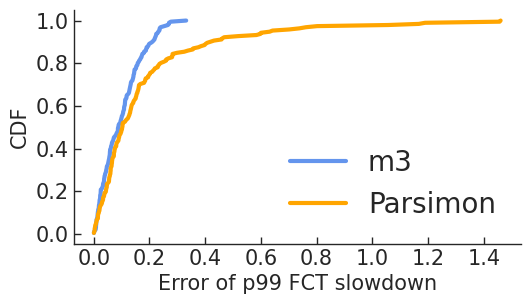

In [12]:
_fontsize=15
records_abs=records.copy()
records_abs['p99__ns3__mlsys']=abs(records_abs['p99__ns3__mlsys'])
records_abs['p99__ns3__pmn_m']=abs(records_abs['p99__ns3__pmn_m'])
column_list=['p99__ns3__mlsys','p99__ns3__pmn_m']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 3.0), sharex=True)
ax.tick_params(axis="y", direction="in")
ax.tick_params(axis="x", direction="in")

for i,each in enumerate(column_list):
    data=records_abs
    data['pct'] = data[each].rank(pct=True)
    ax=sns.lineplot(data = data, x = each, y = 'pct', color = color_list[i], errorbar=None, ax=ax,linewidth=3,)
    
    # handles = ax.get_legend().get_lines()
    # ax.get_legend().remove()
labels=['m3','Parsimon']
# XXX: This is a dirty hack. Look carefully at the labels!
plt.legend(labels=labels, loc='lower right', frameon=False, ncol=1,prop={"size": _fontsize+5})
sns.despine()
fig.tight_layout()
plt.xlabel('Error of p99 FCT slowdown', fontsize=_fontsize)
plt.ylabel('CDF', fontsize=_fontsize)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)
# plt.xlim(1.0)
plt.savefig('figs/sensitivity_cdf.pdf', bbox_inches='tight',pad_inches=0)
print(f"median: {np.median(records_abs['p99__ns3__mlsys'])},{np.median(records_abs['p99__ns3__pmn_m'])}\n 90%: {np.percentile(records_abs['p99__ns3__mlsys'], 90)},{np.percentile(records_abs['p99__ns3__pmn_m'], 90)}\n max: {np.max(records_abs['p99__ns3__mlsys'])},{np.max(records_abs['p99__ns3__pmn_m'])}")

['mlsys_time: 40.0, 47.0, 56 ', 'pmn-m_time: 187.5, 373.9, 470 ', 'ns3_time: 160604.0, 237745.5, 263038 ']


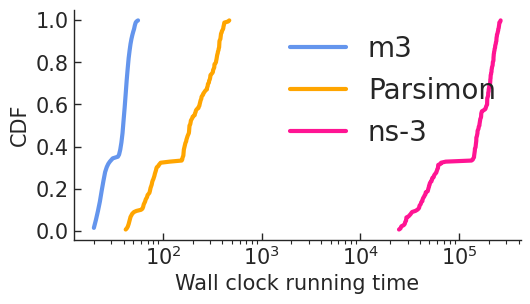

In [13]:
_fontsize=15
column_list=['mlsys_time','pmn-m_time','ns3_time']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 3.0), sharex=True)
ax.tick_params(axis="y", direction="in")
ax.tick_params(axis="x", direction="in")

for i,each in enumerate(column_list):
    data=records
    data['pct'] = data[each].rank(pct=True)
    ax=sns.lineplot(data = data, x = each, y = 'pct', color = color_list[i], errorbar=None, ax=ax,linewidth=3,)
    
    # handles = ax.get_legend().get_lines()
    # ax.get_legend().remove()
labels=['m3','Parsimon', 'ns-3']
# XXX: This is a dirty hack. Look carefully at the labels!
plt.legend(labels=labels, loc='upper right', frameon=False, ncol=1,prop={"size": _fontsize+5})
plt.xscale('log')
sns.despine()
fig.tight_layout()
plt.xlabel('Wall clock running time', fontsize=_fontsize)
plt.ylabel('CDF', fontsize=_fontsize)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)
# plt.xlim(1.0)
plt.savefig('figs/sensitivity_cdf_time.pdf', bbox_inches='tight',pad_inches=0)
print([f"{each}: {np.median(records[each])}, {np.percentile(records[each], 90)}, {np.max(records[each])} " for each in column_list])

0.7748544133669228
0.75


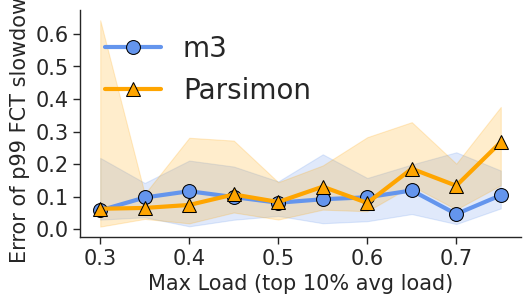

In [14]:
_fontsize=15
records_abs=records.copy()
records_abs['p99__ns3__mlsys']=abs(records_abs['p99__ns3__mlsys'])
records_abs['p99__ns3__pmn_m']=abs(records_abs['p99__ns3__pmn_m'])

# records_abs.loc[records_abs['max_load'] < 0.3, 'max_load'] = 0.3
print(max(records_abs['max_load']))
records_abs['max_load']=records_abs['max_load']//0.05*0.05
print(max(records_abs['max_load']))
records_abs=records_abs[records_abs['max_load']>=0.3]

records_abs=records_abs.sort_values(by='max_load')
column_list=['p99__ns3__mlsys','p99__ns3__pmn_m']
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 3.0), sharex=True)
labels=['m3','Parsimon']
for i,each in enumerate(column_list):
    # ax=sns.scatterplot(data = records_abs, x = 'max_load', y = each, color = color_list[i], ax=axs, marker=markertype_list[i], s=30)
    ax = sns.lineplot(data=records_abs, x='max_load', y=each, color=color_list[i], ax=axs, marker=markertype_list[i], label=labels[i], errorbar=("ci", 100), estimator='median', lw=3,markeredgecolor='black',markersize=10)
    # ax=sns.lineplot(data=records_abs, x='max_load', y=each, color=color_list[i], ax=axs, marker=markertype_list[i], label=each, ci=None, estimator='mean', lw=2)
    # sns.scatterplot(x='max_load', y=each, data=records_abs, color=color_list[i], ax=axs, label=f'{each} Raw', s=30)
    
    # print(f"{each}: ",records_abs[each].min(),records_abs[each].max())
    # handles = ax.get_legend().get_lines()
    # ax.get_legend().remove()

# XXX: This is a dirty hack. Look carefully at the labels!
# fig.legend(loc='upper right', frameon=False, ncol=1)
# plt.ylim(0,0.4)
plt.legend(loc='upper left', frameon=False, ncol=1,prop={"size": _fontsize+5})
sns.despine()
fig.tight_layout()
plt.xlabel('Max Load (top 10% avg load)',fontsize=_fontsize)
plt.ylabel('Error of p99 FCT slowdown',fontsize=_fontsize)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)

plt.savefig('figs/sensitivity_error_over_load.pdf', bbox_inches='tight')

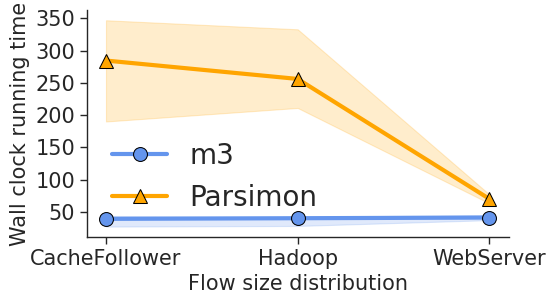

In [15]:
_fontsize=15
records_time=records.copy()

records_time['max_load']=records_time['max_load']//0.08*0.08
key_x='size_dist'
records_time=records_time.sort_values(by=key_x)
column_list=['mlsys_time','pmn-m_time']
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5.2, 3.0), sharex=True)
labels=['m3','Parsimon',"ns-3"]
for i,each in enumerate(column_list):
    
    ax = sns.lineplot(data=records_time, x=key_x, y=each, color=color_list[i], ax=axs, marker=markertype_list[i], label=labels[i], errorbar=("ci", 100), estimator='median', lw=3,markeredgecolor='black',markersize=10)
    
# XXX: This is a dirty hack. Look carefully at the labels!
# fig.legend(loc='upper right', frameon=False, ncol=1)
plt.legend(loc='lower left', frameon=False, ncol=1,prop={"size": _fontsize+5})
# plt.yscale('log')
sns.despine()
fig.tight_layout()
plt.xlabel('Flow size distribution',fontsize=_fontsize)
plt.ylabel('Wall clock running time',fontsize=_fontsize)
plt.yticks(fontsize=_fontsize)
plt.xticks(fontsize=_fontsize)
plt.savefig('figs/sensitivity_time_over_load.pdf', bbox_inches='tight')

## Everything else (fix moderate load)

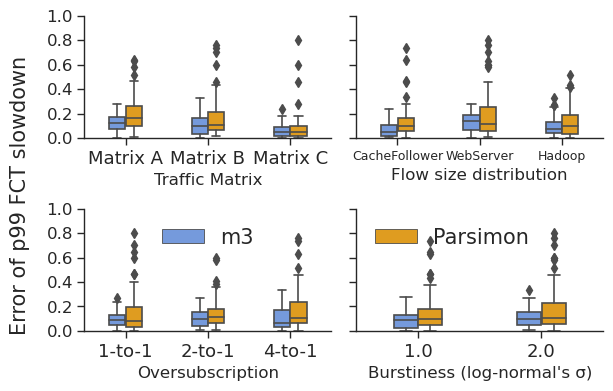

In [16]:
def violins(df):
    xs_labels_orders_rot = [
        ('matrix', 'Traffic Matrix', ['Matrix A', 'Matrix B', 'Matrix C'], 0),
        ('oversub', 'Oversubscription', ['1-to-1', '2-to-1', '4-to-1'], 0),
        ('size_dist', 'Flow size distribution', ['CacheFollower', 'WebServer', 'Hadoop'], 0),
        ('lognorm_sigma', 'Burstiness (log-normal\'s σ)', [1.0, 2.0], 0),
    ]
    legend_loc_list=['upper right','upper center','upper left','upper left']
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6.2, 4.), sharey=True)
    # Define a custom color palette with the same colors for both sns and plt
    custom_palette = ["cornflowerblue",
    "orange",]
    for i, (x, label, order, rot) in enumerate(xs_labels_orders_rot):
        j, k = i % 2, int(i / 2)

        # Create a list of colors for each violin
        # colors = [f'C{i}' for i in range(len(df['kind'].unique()))]
        ax = sns.boxplot(
            data=df[df[x].isin(order)],
            x=x,
            y='error',
            hue='kind',
            order=order,
            ax=axs[j, k],
            palette=custom_palette,
            width=0.4,
             dodge=0.8, 
        )
        ax.set_xlabel(label,fontsize=12)
        for tick in ax.get_xticklabels():
            tick.set_rotation(rot)
            if i != 2:
                tick.set_fontsize(13)
            else:
                tick.set_fontsize(9)
        ax.set_ylabel('')
        ax.set_ylim(0, 1.0)
        for tick in ax.get_yticklabels():
            tick.set_rotation(rot)
            tick.set_fontsize(12)
        if i == 1:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles[0:1], labels=labels[0:1], frameon=False, loc=legend_loc_list[i], prop={"size": 15})
        elif i == 3:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles=handles[1:], labels=labels[1:], frameon=False, loc=legend_loc_list[i], prop={"size": 15})
        else:
            ax.get_legend().remove()  # Hide the legend on other plots
    # Remove "kind" from the legend
    # for idx,ax in enumerate(axs.flat):
    #     handles, labels = ax.get_legend_handles_labels()
    #     ax.legend(handles=handles[0:], labels=labels[0:],frameon=False,loc=legend_loc_list[idx],prop={"size": 15})
    sns.despine()
    fig.supylabel('Error of p99 FCT slowdown',fontsize=15)
    fig.tight_layout()

# Assuming records and 'kind' column are defined somewhere in your script
df_violin_pmn = records.copy()
df_violin_mlsys = records.copy()
df_violin_pmn['kind'] = 'Parsimon'
df_violin_pmn['error'] = abs(df_violin_pmn["p99__ns3__pmn_m"])
df_violin_mlsys['kind'] = 'm3' 
df_violin_mlsys['error'] = abs(df_violin_mlsys["p99__ns3__mlsys"])
df_violin = pd.concat([df_violin_mlsys,df_violin_pmn], ignore_index=True)

violins(df_violin)
plt.savefig('figs/sensitivity_boxplot.pdf', bbox_inches='tight')
